In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from datetime import date,datetime
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Model selection and evaluation tools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.metrics import precision_score, average_precision_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Data processing
from sklearn.preprocessing import StandardScaler

In [6]:
import sys
sys.path.insert(0, '../')
from statlearning import plot_coefficients

In [7]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

# Revolving Door Analysis

You belong to the people analytics team for a food conglomorate. Employee turnover has been rampant for your 10 subsidiaries. 
Your team has been tasked with diagnosing why and when employees from your subsidiaries leave.
The goal is to predict employee retention and understand its main drivers
Also what are your recommendations and why?


# Data Wrangling

In [8]:
df = pd.read_csv('employee_retention.csv')
print('Number of rows:',len(df))

Number of rows: 34702


In [9]:
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [10]:
df.dtypes

Unnamed: 0       int64
employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [11]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
df['employee_id'] = df['employee_id'].fillna(0.0).astype(int)

In [13]:
print(len(df.employee_id))
print(len(df.employee_id.unique()))
print(len(df.company_id))
print(len(df.company_id.unique()))

34702
34702
34702
12


34702 unique employees records and 12 unique companies.

In [14]:
sorted(df.company_id.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [15]:
df['dept'].value_counts()

temp_contractor     10000
customer_service     9180
engineer             4613
data_science         3190
sales                3172
marketing            3167
design               1380
Name: dept, dtype: int64

In [16]:
df["Cleaned_Dept"] = df["dept"].astype('category')
df["Cleaned_Dept"] .cat.categories

Index(['customer_service', 'data_science', 'design', 'engineer', 'marketing',
       'sales', 'temp_contractor'],
      dtype='object')

In [17]:
# for col in df.columns:
#     print(col)
#     true_strings = pd.to_numeric(df[col],
#                                 errors='coerce').isnull()
#     print('Number of true strings: {}'.format(df.loc[true_strings, col].count()))
#     print('List of true strings: {}'.format(df.loc[true_strings, col].unique()))
#     print(df.loc[true_strings, col])
#     print('-'*50)

In [18]:
df['quit_date'] = pd.to_datetime(df['quit_date'])
df['join_date'] = pd.to_datetime(df['join_date'])
df['stay_length_M'] = (df['quit_date']-df['join_date'])/np.timedelta64(1, 'M')
df['stay_length_M'].describe()

count    23510.000000
mean        12.840386
std         11.802241
min          2.956940
25%          2.956940
50%         11.039241
75%         19.910060
max         56.707530
Name: stay_length_M, dtype: float64

In [19]:
df['stay_length_Y'] = (df['quit_date']-df['join_date'])/np.timedelta64(1, 'Y')
df['stay_length_Y'].describe()

count    23510.000000
mean         1.070032
std          0.983520
min          0.246412
25%          0.246412
50%          0.919937
75%          1.659172
max          4.725627
Name: stay_length_Y, dtype: float64

In [20]:
print(r'min_quit_date:',min(df['quit_date']))
print(r'max_quit_date:',max(df['quit_date']))
print(r'min_join_date:',min(df['join_date']))
print(r'max_join_date:',max(df['join_date']))
print(r'min_stay_length(in Years):',min(df['stay_length_Y']))
print(r'max_stay_length(in Years):',max(df['stay_length_Y']))

min_quit_date: 2007-04-01 00:00:00
max_quit_date: 2015-12-09 00:00:00
min_join_date: 2007-01-01 00:00:00
max_join_date: 2015-12-10 00:00:00
min_stay_length(in Years): 0.24641163062896568
max_stay_length(in Years): 4.725627494062164


In [21]:
df['quit'] = df['quit_date'].notnull()

In [22]:
# checking missing data in data 
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
stay_length_Y,11192,32.251743
stay_length_M,11192,32.251743
quit_date,11192,32.251743
salary,239,0.688721
quit,0,0.000000


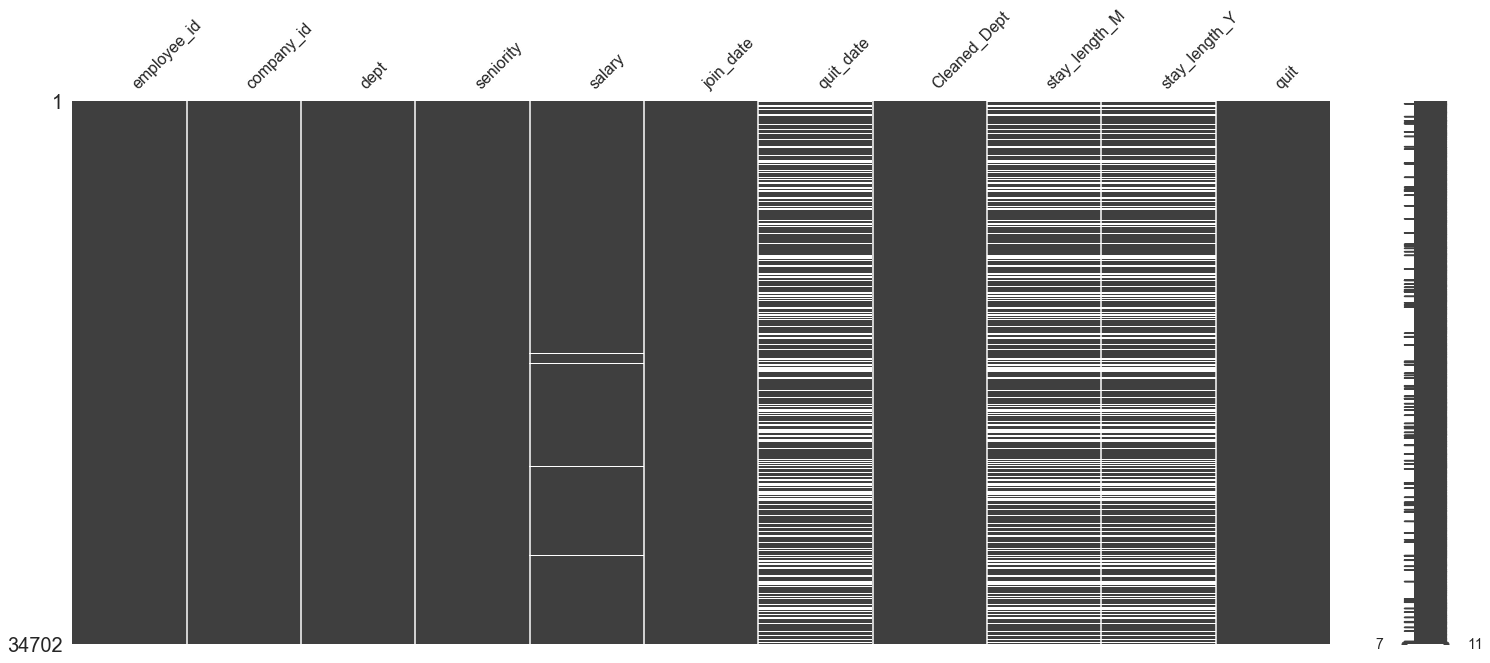

In [23]:
msno.matrix(df);

# EDA

In [24]:
df['quit'].sum()

23510

## About 23K employees left the companies over 9 years (2007-04-01 to 2015-12-09). Based on 100k replacement cost per employee, this had cost the company 2.3 billion dollars.

In [25]:
df_no_nan = df.dropna()

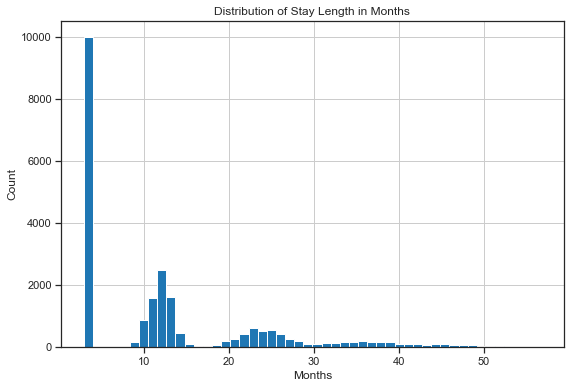

In [26]:
fig, ax = plt.subplots()
df['stay_length_M'].hist(bins=50)
plt.xlabel('Months')
plt.ylabel('Count')
ax.set_title('Distribution of Stay Length in Months');

In [27]:
employee_df = df_no_nan.groupby('employee_id').mean()
employee_df.head()

,company_id,seniority,salary,stay_length_M,stay_length_Y,quit
employee_id,,,,,,
36,4,29,226000.0,26.349617,2.195801,True
70,2,6,220000.0,10.710692,0.892558,True
255,1,27,315000.0,48.132405,4.011034,True
273,1,28,124000.0,24.049775,2.004148,True
289,2,11,60000.0,39.458716,3.288226,True


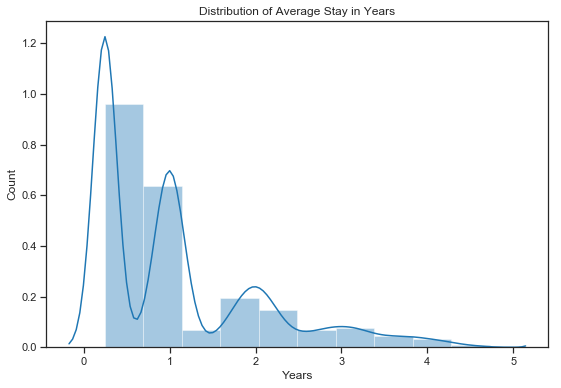

In [28]:
fig, ax = plt.subplots()
sns.distplot(employee_df['stay_length_Y'], bins=10, kde=True, ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Average Stay in Years');

## Most of the people stay less than half a year: huge turnover!

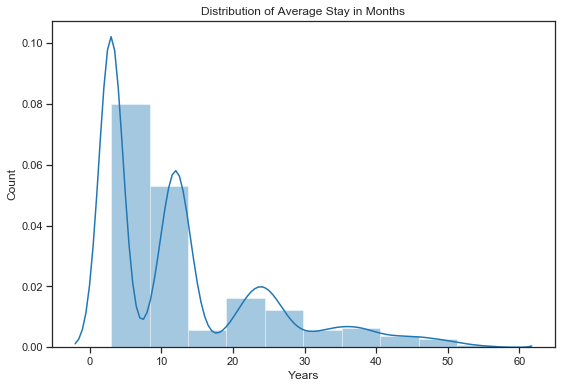

In [29]:
fig, ax = plt.subplots()
sns.distplot(employee_df['stay_length_M'], bins=10, kde=True, ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Average Stay in Months');

In [30]:
trend_ts_df = df[['quit_date','stay_length_M','stay_length_Y']]
trend_ts_df = trend_ts_df.sort_values('quit_date',ascending=True)
trend_ts_df.set_index('quit_date', inplace=True)
trend_ts_df.head()

,stay_length_M,stay_length_Y
quit_date,,
2007-04-01,2.95694,0.246412
2007-04-01,2.95694,0.246412
2007-04-01,2.95694,0.246412
2007-04-01,2.95694,0.246412
2007-04-01,2.95694,0.246412


In [31]:
trend_ts_df_mean = trend_ts_df.groupby('quit_date').mean()
trend_ts_df_mean.head()

,stay_length_M,stay_length_Y
quit_date,,
2007-04-01,2.95694,0.246412
2007-04-02,2.95694,0.246412
2007-04-03,2.95694,0.246412
2007-04-04,2.95694,0.246412
2007-04-05,2.95694,0.246412


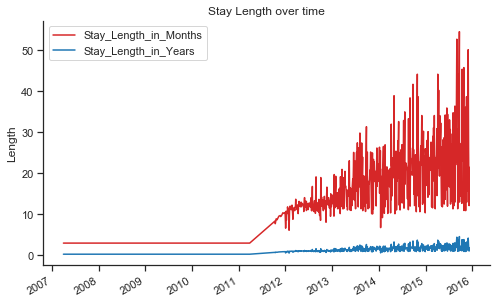

In [32]:
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
fig, ax = plt.subplots(figsize=(8,5))
trend_ts_df_mean['stay_length_M'].plot(color=red)
trend_ts_df_mean['stay_length_Y'].plot(color=blue)
ax.set_xlabel('')
ax.set_ylabel('Length')
ax.legend(['Stay_Length_in_Months','Stay_Length_in_Years'])
ax.set_title('Stay Length over time')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

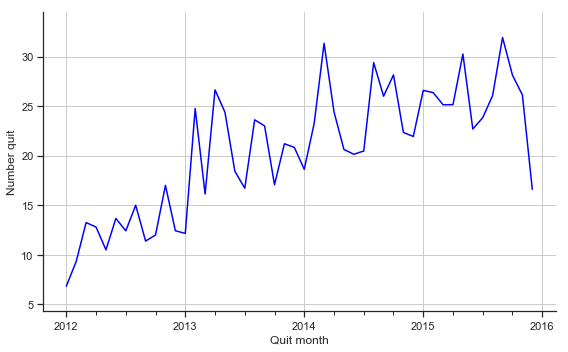

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
filtered_df = df[df['quit_date'] > '2011/12/31']
df_quit_date = filtered_df.groupby('quit_date')['quit_date'].count().resample('M').mean()
df_quit_date.plot(kind='line',colormap='winter')
plt.ylabel('Number quit')
plt.xlabel('Quit month')
ax.axis('equal')
ax.grid(True)
sns.despine()
plt.tight_layout()
# plt.savefig('quitcount.png')

# Increasing trend in number of quits over the years.

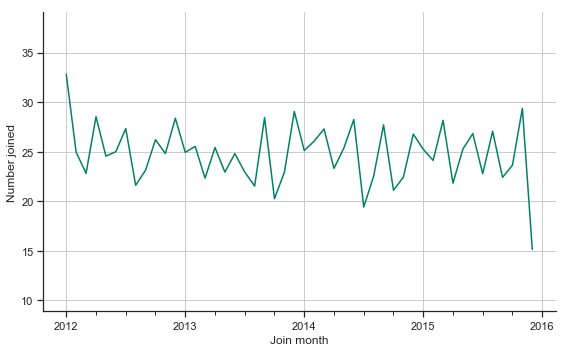

In [34]:
fig, ax = plt.subplots(figsize=(8,5))
filtered_df = df[df['join_date'] > '2011/12/31']
df_join_date = filtered_df.groupby('join_date')['join_date'].count().resample('M').mean()
df_join_date.plot(kind='line',colormap='summer')
plt.ylabel('Number joined')
plt.xlabel('Join month')
ax.axis('equal')
ax.grid(True)
sns.despine()
plt.tight_layout()
#plt.savefig('joincount.png')

*Fairly stable of people joining the company: between 20 to 30 people on average a month.*

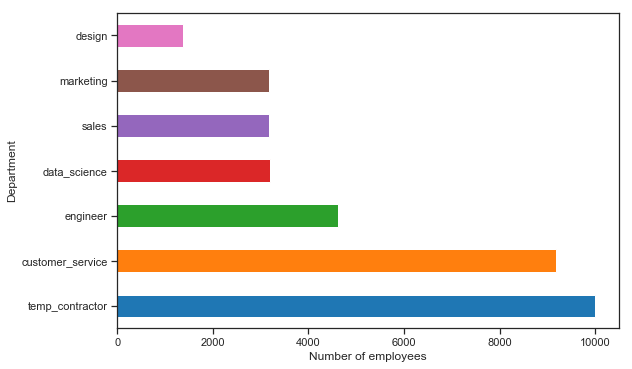

In [35]:
df['dept'].value_counts().plot(kind='barh')
plt.ylabel('Department')
plt.xlabel('Number of employees')
plt.gcf().subplots_adjust(bottom=0.15)

In [36]:
df[(df['company_id'] == 11)].count()

employee_id      16
company_id       16
dept             16
seniority        16
salary           16
join_date        16
quit_date        12
Cleaned_Dept     16
stay_length_M    12
stay_length_Y    12
quit             16
dtype: int64

In [37]:
df[(df['company_id'] == 12)].count()

employee_id      24
company_id       24
dept             24
seniority        24
salary           23
join_date        24
quit_date        12
Cleaned_Dept     24
stay_length_M    12
stay_length_Y    12
quit             24
dtype: int64

In [38]:
df[(df['company_id'] == 1)].count()

employee_id      9501
company_id       9501
dept             9501
seniority        9501
salary           9423
join_date        9501
quit_date        5636
Cleaned_Dept     9501
stay_length_M    5636
stay_length_Y    5636
quit             9501
dtype: int64

Not quite sure what are companies 11 and 12, dropping them.

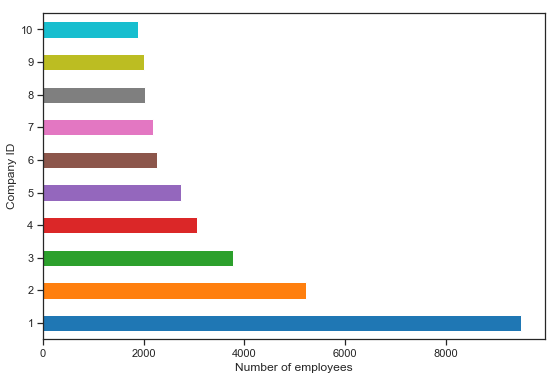

In [39]:
df.drop(df[(df['company_id'] == 11)].index, inplace=True)
df.drop(df[(df['company_id'] == 12)].index, inplace=True)
df['company_id'].value_counts().plot(kind='barh')
plt.xlabel("Number of employees")
plt.ylabel("Company ID")
plt.savefig('companies.png')

In [40]:
group_dept = df.groupby(['dept'])
stay_length_per_dept = group_dept['stay_length_M'].mean()
stay_length_per_dept.head()

dept
customer_service    19.800309
data_science        21.379327
design              19.805372
engineer            21.349776
marketing           19.731987
Name: stay_length_M, dtype: float64

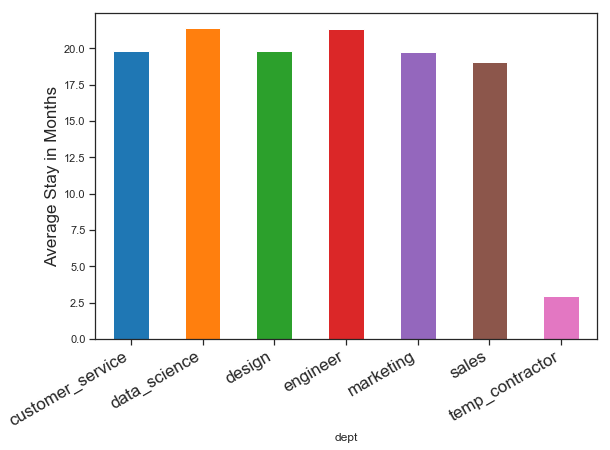

In [41]:
stay_length_per_dept.plot.bar()
_ = plt.ylabel(r'Average Stay in Months', fontsize=17)
ax = plt.gca()
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, rotation = 30, ha='right')

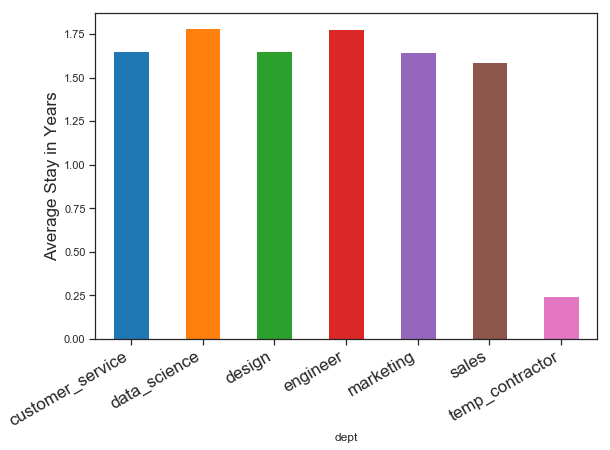

In [42]:
stay_length_per_dept = group_dept['stay_length_Y'].mean()
stay_length_per_dept.plot.bar()
_ = plt.ylabel(r'Average Stay in Years', fontsize=17)
ax = plt.gca()
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, rotation = 30, ha='right')

## Average Stay is about 1 year and half cross departments. Contractors per nature stay on average 2.5 months.

<Figure size 1080x288 with 0 Axes>

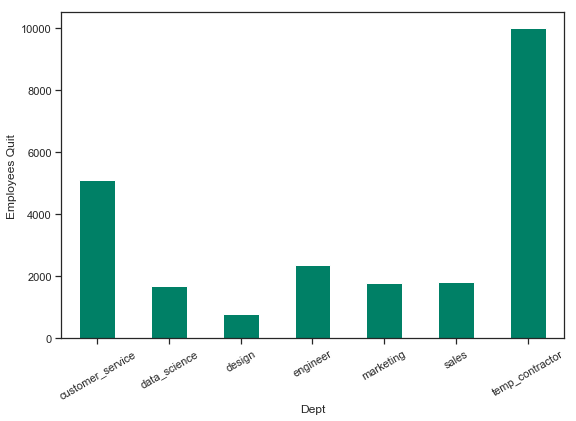

In [43]:
dept_employee_quit = df[['dept','employee_id']].loc[df['quit']==True].groupby('dept').count()
plt.figure(figsize=(15,4));
dept_employee_quit.plot(kind='bar',legend=False,rot=30,colormap='summer');
plt.xlabel('Dept');
plt.ylabel('Employees Quit');

## If we set aside contractors,  people leaving the companies in order are: customer_service, engineer, marketing, sales, data_science.

Dropping for analysis temp_contractor categoru

In [44]:
df.drop(df[(df['dept'] == 'temp_contractor')].index, inplace=True)

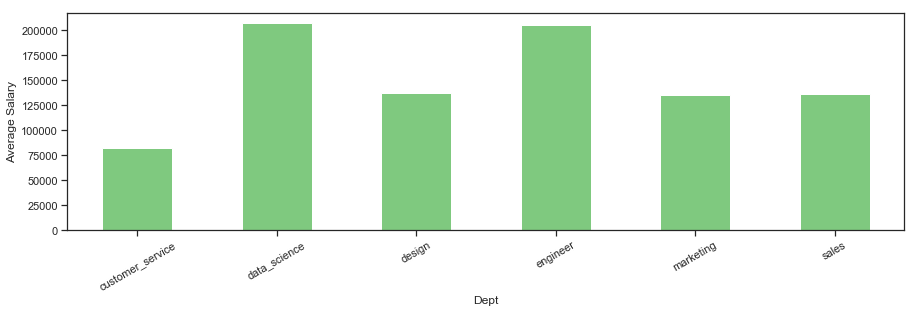

In [45]:
group_dept = df.groupby(['dept'])
mean_salary = group_dept['salary'].mean()
mean_salary.head()
plt.figure(figsize=(15,4));
mean_salary.plot(kind='bar',legend=False,rot=30,colormap='Accent');
plt.xlabel('Dept');
plt.ylabel('Average Salary');

## Maybe salary is a factor for customer service turnover but probably not for the other departments.

<Figure size 1080x288 with 0 Axes>

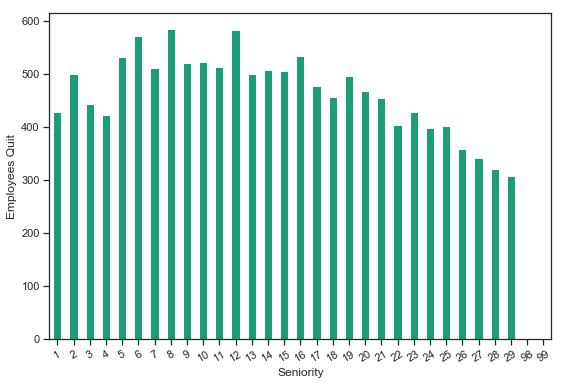

In [46]:
seniority_employee_quit = df[['seniority','employee_id']].loc[df['quit']==True].groupby('seniority').count()
plt.figure(figsize=(15,4));
seniority_employee_quit.plot(kind='bar',legend=False,rot=30,colormap='Dark2');
plt.xlabel('Seniority');
plt.ylabel('Employees Quit');

## It seems there is a "soft" point in the range of 5 to 19 months of seniority.

In [47]:
group_company = df.groupby(['company_id'])
stay_length_per_company = group_company['stay_length_M'].mean()
stay_length_per_company.head()

company_id
1    20.243500
2    20.655863
3    20.029183
4    19.700792
5    20.018584
Name: stay_length_M, dtype: float64

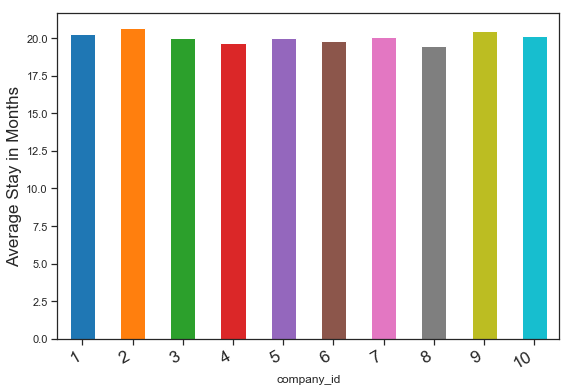

In [48]:
stay_length_per_company.plot.bar()
_ = plt.ylabel(r'Average Stay in Months', fontsize=17)
ax = plt.gca()
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, rotation = 30, ha='right')

In [49]:
stay_length_per_company/max(stay_length_per_company)*100

company_id
1      98.003654
2     100.000000
3      96.966092
4      95.376271
5      96.914783
6      95.990849
7      97.002867
8      94.315586
9      98.956874
10     97.450109
Name: stay_length_M, dtype: float64

## People stay the less in companies: 6,7,8,9,10.

## Computing TurnOver

In [50]:
df_turnover = pd.DataFrame(df[['company_id','employee_id']].loc[df['quit']==False].groupby('company_id').count())
df_turnover.columns = ['current_employees']
df_turnover['total_quit'] = df[['company_id','employee_id']].loc[df['quit']==True].groupby('company_id').count()
df_turnover['turnover'] = df_turnover['current_employees']/df_turnover['total_quit']
df_turnover.head()

,current_employees,total_quit,turnover
company_id,,,
1,3865,4621,0.836399
2,2016,2206,0.913871
3,1218,1531,0.795558
4,909,1153,0.788378
5,772,983,0.785351


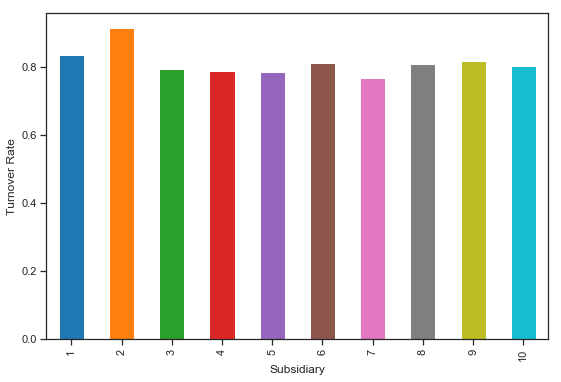

In [51]:
df_turnover['turnover'].plot(kind='bar',legend=False)
plt.xlabel('Subsidiary')
plt.ylabel('Turnover Rate');

## Consistent turnover cross subsidiaries.

# Modelisation

In [52]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Cleaned_Dept,stay_length_M,stay_length_Y,quit
1,388804,8,design,21,191000.0,2011-05-17,2012-03-16,design,9.987885,0.832324,True
2,407990,3,design,9,90000.0,2012-03-26,2015-04-10,design,36.468921,3.039077,True
3,120657,2,engineer,20,298000.0,2013-04-08,2015-01-30,engineer,21.749933,1.812494,True
5,287530,5,marketing,20,180000.0,2014-06-30,NaT,marketing,NaN,NaN,False
6,561043,3,customer_service,18,119000.0,2012-07-02,2014-03-28,customer_service,20.829997,1.735833,True


In [53]:
df.dtypes

employee_id               int64
company_id                int64
dept                     object
seniority                 int64
salary                  float64
join_date        datetime64[ns]
quit_date        datetime64[ns]
Cleaned_Dept           category
stay_length_M           float64
stay_length_Y           float64
quit                       bool
dtype: object

In [54]:
df_model = df[['company_id','Cleaned_Dept','seniority','salary','quit']]
df_model['Dept'] = df_model['Cleaned_Dept']
df_model.drop('Cleaned_Dept', axis=1, inplace=True)
df_model['tenure'] = df['quit_date'] - df['join_date']
df_model['tenure'] = df_model['tenure'].apply(lambda x: int(x.days) if not (np.isnan(x.days)) else x)
df_model.head()

,company_id,seniority,salary,quit,Dept,tenure
1,8,21,191000.0,True,design,304
2,3,9,90000.0,True,design,1110
3,2,20,298000.0,True,engineer,662
5,5,20,180000.0,False,marketing,NaT
6,3,18,119000.0,True,customer_service,634


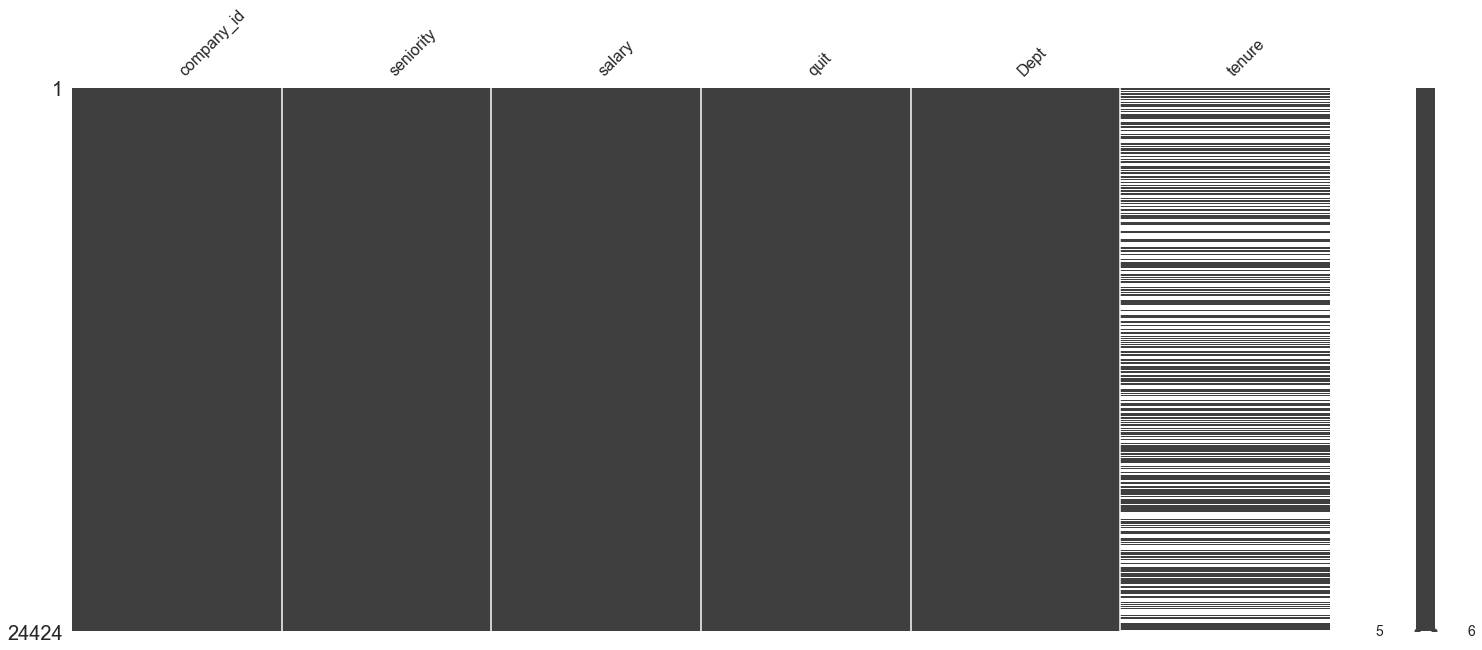

In [55]:
df_model.dropna(subset=['seniority', 'salary'],inplace=True);
msno.matrix(df_model);

In [56]:
# Response for survival
df_y = df_model[['Dept','quit', 'tenure']]
df_y = df_y[df_y.tenure.notnull()]
print(len(df_y))

13355


In [57]:
# Survival Analysis
time, survival_prob = kaplan_meier_estimator(df_y['quit'], df_y['tenure'])

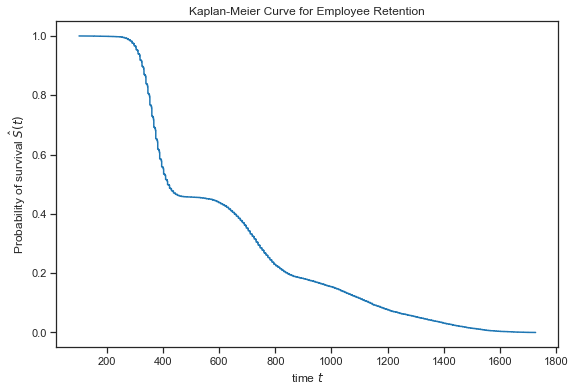

In [58]:
plt.step(time, survival_prob, where="post")
plt.ylabel("Probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Kaplan-Meier Curve for Employee Retention');

Text(0,0.5,'Probability of survival $\\hat{S}(t)$')

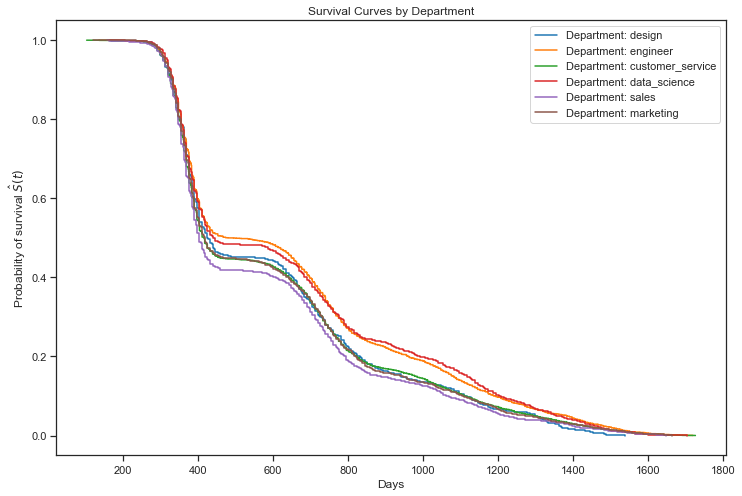

In [59]:
# Survival curves for each department
dept_vals = df_y['Dept'].unique()
plt.figure(figsize=(12,8))
for i in dept_vals:
    mask_treat = df_model['Dept'] == i
    time_emply, survival_emply = kaplan_meier_estimator(
        df_y['quit'][mask_treat],
        df_y['tenure'][mask_treat])
    
    plt.step(time_emply, survival_emply, where="post",
             label="Department: %s" % str(i))
plt.legend(loc="best")
plt.title('Survival Curves by Department')
plt.xlabel('Days')
plt.ylabel('Probability of survival $\hat{S}(t)$')

We are going to stop here with the survival analysis: people quit after 1600 days. 

In [60]:
# Define which columns should be encoded vs scaled
# columns_to_scale  = ['seniority','salary']
# Instantiate encoder/scaler
# scaler = StandardScaler()
# scaled_values  = scaler.fit_transform(df_model[columns_to_scale]) 
# print(scaled_values.shape)
columns  = ['seniority','salary']
values_of_interests = df_model[columns]
print(values_of_interests.shape)

(24424, 2)


In [61]:
df_model = pd.get_dummies(df_model, columns=['company_id', 'Dept'])
df_model.columns

Index(['seniority', 'salary', 'quit', 'tenure', 'company_id_1', 'company_id_2',
       'company_id_3', 'company_id_4', 'company_id_5', 'company_id_6',
       'company_id_7', 'company_id_8', 'company_id_9', 'company_id_10',
       'Dept_customer_service', 'Dept_data_science', 'Dept_design',
       'Dept_engineer', 'Dept_marketing', 'Dept_sales',
       'Dept_temp_contractor'],
      dtype='object')

In [62]:
cols_to_use = df_model.columns[4:].values
print(df_model[cols_to_use].columns)
X = np.concatenate([values_of_interests, df_model[cols_to_use]], axis=1)
X.shape

Index(['company_id_1', 'company_id_2', 'company_id_3', 'company_id_4',
       'company_id_5', 'company_id_6', 'company_id_7', 'company_id_8',
       'company_id_9', 'company_id_10', 'Dept_customer_service',
       'Dept_data_science', 'Dept_design', 'Dept_engineer', 'Dept_marketing',
       'Dept_sales', 'Dept_temp_contractor'],
      dtype='object')


(24424, 19)

In [64]:
features_names = columns.copy()
features_names.extend(list(df_model[cols_to_use].columns.values))
print(features_names)

['seniority', 'salary', 'company_id_1', 'company_id_2', 'company_id_3', 'company_id_4', 'company_id_5', 'company_id_6', 'company_id_7', 'company_id_8', 'company_id_9', 'company_id_10', 'Dept_customer_service', 'Dept_data_science', 'Dept_design', 'Dept_engineer', 'Dept_marketing', 'Dept_sales', 'Dept_temp_contractor']


In [65]:
y = df_model['quit']
y = y.astype('int')

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(18318, 19)

## Logistic Regression

In [67]:
np.logspace(-5,5,11)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [69]:
%%time
model = LogisticRegression()
#model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':np.logspace(-5,5,11),
    'class_weight':['balanced',None],
    'penalty':['l1','l2']
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 10, n_iter= 44, return_train_score=False, n_jobs=4,
                              random_state = 20)
lr_search.fit(X_train, y_train)
print('Best parameters:', lr_search.best_params_)
logit = lr_search.best_estimator_

Best parameters: {'penalty': 'l1', 'class_weight': None, 'C': 1.0}
CPU times: user 552 ms, sys: 150 ms, total: 702 ms
Wall time: 5.04 s


## Support Vector Machines

## Linear Support Vector Classifier

In [70]:
%%time
# Linear SVC tuning with grid search cross validation
from sklearn.svm import LinearSVC

#Cs = list(np.logspace(-15, 15, 31, base=2))
Cs = list(np.logspace(-5,5,11))
model = Pipeline((
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(loss='hinge')),
))

tuning_parameters ={
    'clf__C': Cs,
}

svm_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=4)
svm_search.fit(X_train, y_train)

svm_linear = svm_search.best_estimator_

print('Best parameter found by randomised search:', svm_search.best_params_, '\n')

Best parameter found by randomised search: {'clf__C': 1e-05} 

CPU times: user 222 ms, sys: 34.6 ms, total: 256 ms
Wall time: 18 s


## Polynomial Kernel

In [73]:
# %%time 
# Polynomial kernel SVC tuning with grid search cross validation

#Cs = list(np.logspace(-12, 12, 25, base=2))

# Cs = list(np.logspace(-5,5,5))
# model = Pipeline([
#     #('scaler', StandardScaler()),
#     ('clf', SVC(kernel='poly', degree=2, coef0=1.0)),
# ])


# tuning_parameters ={
#     'clf__C': Cs,
# }

# svm_search = RandomizedSearchCV(model, tuning_parameters, cv=5, n_iter = 4, return_train_score=False, n_jobs=4, 
#                                 random_state = 20)
# svm_search.fit(X_train, y_train)

# svm_poly = svm_search.best_estimator_

# print('Best parameters found by randomised search:', svm_search.best_params_, '\n')

## Model Evaluation

In [74]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Logistic regression', 'Linear SVC', 'SVM (Polynomial kernel)', 'SVM (Gaussian RBF kernel)']
#rows=['Logistic regression', 'Linear SVC', 'SVM (Polynomial kernel)', 'SVM (Gaussian RBF kernel)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

models=[logit, svm_linear]
#models=[logit, svm_linear, svm_poly,  svm_rbf]

y_df = np.zeros((len(y_test), len(rows)))

for i, model in enumerate(models):
    
    y_pred = model.predict(X_test)
    
    confusion  = confusion_matrix(y_test, y_pred)
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,4]=  precision_score(y_test, y_pred)
    y_df[:,i] = model.decision_function(X_test)    
    results.iloc[i,3] = roc_auc_score(y_test, y_df[:,i])

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Logistic regression,0.456,0.943,0.084,0.517,0.543
Linear SVC,0.458,0.843,0.195,0.509,0.547
SVM (Polynomial kernel),0.000,0.000,0.000,0.000,0.000
SVM (Gaussian RBF kernel),0.000,0.000,0.000,0.000,0.000


In [75]:
def plot_roc_curves_orig(y_test, y_probs, labels, sample_weight=None):
    fig, ax = plt.subplots(figsize=(9, 6))

    N, M = y_probs.shape

    for i in range(M):
        fpr, tpr, _ = roc_curve(y_test, y_probs[:, i], sample_weight=sample_weight)
        auc = roc_auc_score(y_test, y_probs[:, i], sample_weight=sample_weight)
        ax.plot(fpr, tpr, label=labels.iloc[i] + ' (AUC = {:.3f})'.format(auc))

    ax.plot([0, 0], [1, 1], linestyle='--', color='black', alpha=0.6)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title('ROC curves', fontsize=14)
    sns.despine()

    plt.legend(fontsize=13, loc='lower right')

    return fig, ax

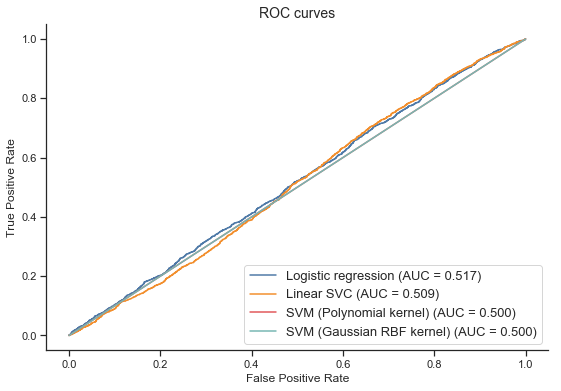

In [76]:
#from statlearning import plot_roc_curves_orig

with sns.color_palette(crayon):
    fig, ax = plot_roc_curves_orig(y_test, y_df, labels=pd.Series(rows))
    plt.show()

## Random Forest Classifier

In [77]:
%%time

model = RandomForestClassifier(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 50, 'max_features': 1} 

CPU times: user 673 ms, sys: 110 ms, total: 783 ms
Wall time: 24.1 s


In [78]:
rf.feature_importances_

array([0.31618398, 0.4936752 , 0.01418697, 0.01770098, 0.01257553,
       0.00950445, 0.00763546, 0.00796264, 0.00595824, 0.00583718,
       0.00422584, 0.00428642, 0.0178859 , 0.01596781, 0.00697386,
       0.03467023, 0.01217941, 0.01258992, 0.        ])

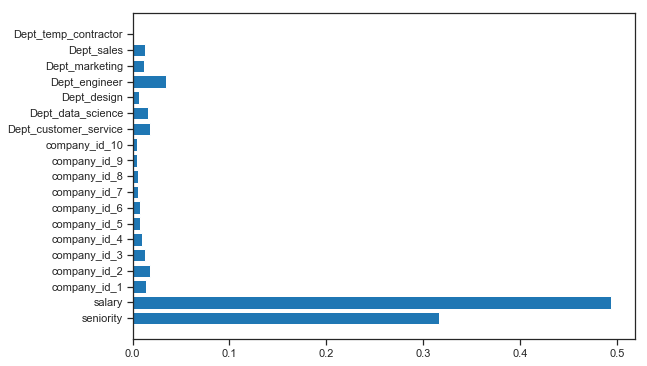

In [79]:
plt.barh(range(X.shape[1]), rf.feature_importances_)
plt.yticks(np.arange(X.shape[1]), features_names)
plt.show()

## Gradient Boosting Classifier

In [80]:
model = GradientBoostingClassifier()
model.get_params().keys()

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [81]:
%%time

model = GradientBoostingClassifier(n_estimators=100)

tuning_parameters = {
    'learning_rate': list(np.logspace(-5,5,11)),
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

gb_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

gb = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 20, 'max_features': 11, 'learning_rate': 0.01} 

CPU times: user 824 ms, sys: 87.1 ms, total: 911 ms
Wall time: 10.8 s


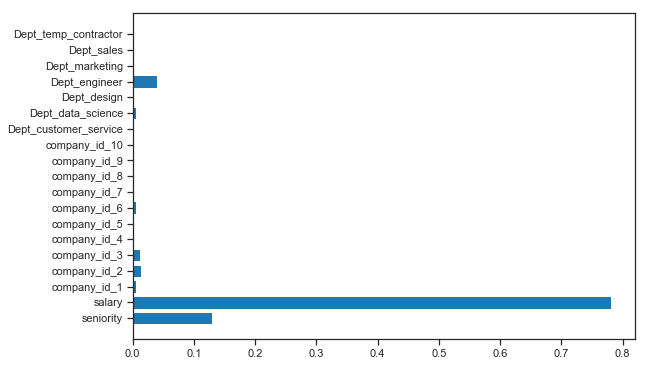

In [82]:
plt.barh(range(X.shape[1]), gb.feature_importances_)
plt.yticks(np.arange(X.shape[1]), features_names)
plt.show()

In [83]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Random Forest', 'Gradient Boosting']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

models=[rf, gb]

y_df = np.zeros((len(y_test), len(rows)))

for i, model in enumerate(models):
    
    y_pred = model.predict(X_test)
    
    confusion  = confusion_matrix(y_test, y_pred)
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,4]=  precision_score(y_test, y_pred)
    y_df[:,i] = model.predict_proba(X_test)[:,1]
    results.iloc[i,3] = roc_auc_score(y_test, y_df[:,i])

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Random Forest,0.454,0.856,0.188,0.536,0.549
Gradient Boosting,0.451,0.926,0.114,0.545,0.547


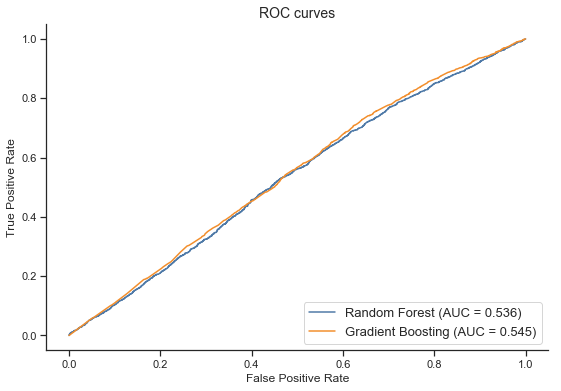

In [84]:
with sns.color_palette(crayon):
    fig, ax = plot_roc_curves_orig(y_test, y_df, labels=pd.Series(rows))
    plt.show()

# Conclusion
* Classifiers have poor performance. 
* The best classifier, Gradient Boosting, predicts that salary and seniority are best predictors of employee turnover.